In [1]:
from IPython.display import *
#HTML('<style> ' + open('../demo.css').read() + '</style>')

# Plotting drastically different time series

Plotting multiple time series on a single graph is always a challenge. The challenge becomes especially difficult when the time series are very different one from another.
In this exercise, we will plot dynamics of the number confirmed COVID-19 cases in several countries

## Setup & ingress

In [2]:
import pandas as pd
import os
from matplotlib import pylab as plt
import seaborn as sns
import numpy as np
import ipywidgets
import matplotlib as mpl
%matplotlib inline

In [3]:
url = 'https://opendata.ecdc.europa.eu/covid19/casedistribution/csv'
try:
    df_covid = pd.read_csv(url)
except:
    print(f'Failed to download from {url}. Loading from the disk')
    df_covid = pd.read_csv('../data/covid_cases.csv')
df_covid.tail()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018
8900,25/03/2020,25,3,2020,0,0,Zimbabwe,ZW,ZWE,14439018.0
8901,24/03/2020,24,3,2020,0,1,Zimbabwe,ZW,ZWE,14439018.0
8902,23/03/2020,23,3,2020,0,0,Zimbabwe,ZW,ZWE,14439018.0
8903,22/03/2020,22,3,2020,1,0,Zimbabwe,ZW,ZWE,14439018.0
8904,21/03/2020,21,3,2020,1,0,Zimbabwe,ZW,ZWE,14439018.0


In [4]:
df_covid['date'] = pd.to_datetime(df_covid.dateRep, dayfirst=True)

In [5]:
countries_of_interest = [
    # OECD countries + some other countries of interest
    'AUS', 'AUT', 'BEL', 'CAN', 'CHE', 'CHL', 'CHN', 'CZE', 'DEU', 'DNK', 
    'ESP', 'EST', 'FIN', 'FRA', 'GBR', 'GRC', 'HUN', 'IND', 'IRL', 'ISL', 
    'ISR', 'ITA', 'JPN', 'KOR', 'LUX', 'MEX', 'NLD', 'NOR', 'NZL', 'POL', 
    'PRT', 'SGP', 'SPA', 'SVK', 'SVN', 'SWE', 'TUR', 'TWN', 'USA'
]
df_selected = df_covid.loc[
    df_covid.countryterritoryCode.isin(countries_of_interest)
].sort_values(
    ['geoId', 'date']
).set_index(
    'countryterritoryCode'
).rename(columns={
    'countriesAndTerritories': 'country',
    'popData2018': 'population'
}).drop(
    ['day', 'month', 'year'], axis=1
)
df_selected['country'] = df_selected['country'].str.replace('_', ' ')
df_selected.loc['ISR'].tail()

,dateRep,cases,deaths,country,geoId,population,date
countryterritoryCode,,,,,,,
ISR,01/04/2020,443,3,Israel,IL,8883800.0,2020-04-01
ISR,02/04/2020,675,1,Israel,IL,8883800.0,2020-04-02
ISR,03/04/2020,661,13,Israel,IL,8883800.0,2020-04-03
ISR,04/04/2020,1176,5,Israel,IL,8883800.0,2020-04-04
ISR,05/04/2020,590,7,Israel,IL,8883800.0,2020-04-05


In [6]:
cumcases = df_selected.groupby('geoId').apply(lambda t: pd.DataFrame({ 'date': t.date, 'cumcases': np.cumsum(t.cases)}))
df_selected['date1'] = cumcases['date']
assert (df_selected.date1 == df_selected.date).all()
df_selected.drop('date1', axis=1, inplace=True)
df_selected['cumcases'] = cumcases['cumcases']

In [7]:
df_selected.head()

,dateRep,cases,deaths,country,geoId,population,date,cumcases
countryterritoryCode,,,,,,,,
AUT,31/12/2019,0,0,Austria,AT,8847037.0,2019-12-31,0
AUT,01/01/2020,0,0,Austria,AT,8847037.0,2020-01-01,0
AUT,02/01/2020,0,0,Austria,AT,8847037.0,2020-01-02,0
AUT,03/01/2020,0,0,Austria,AT,8847037.0,2020-01-03,0
AUT,04/01/2020,0,0,Austria,AT,8847037.0,2020-01-04,0


## The default

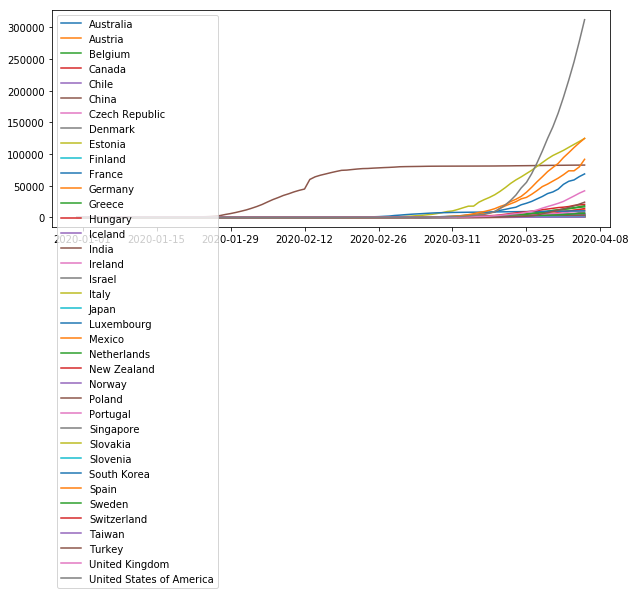

In [8]:
fig_default, ax = plt.subplots(figsize=(10, 4))
for country, df in df_selected.groupby('country'):
    ax.plot(df.date, df.cumcases, '-', label=country)
ax.legend()

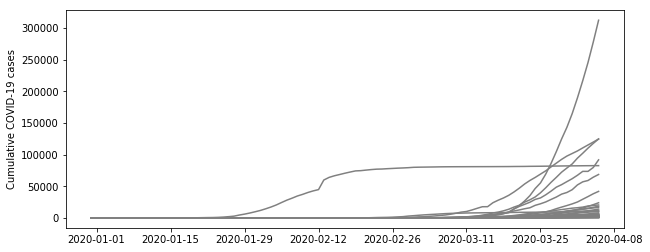

In [9]:
def plot_dynamics(logscale=False):
    fig, ax = plt.subplots(figsize=(10, 4))
    for name, df in df_selected.groupby('country'):
        ax.plot(df.date, df.cumcases, '-', color='gray', label=name)
    ax.set_ylabel('Cumulative COVID-19 cases')
    return ax
plot_dynamics(True)

## Look at what's important

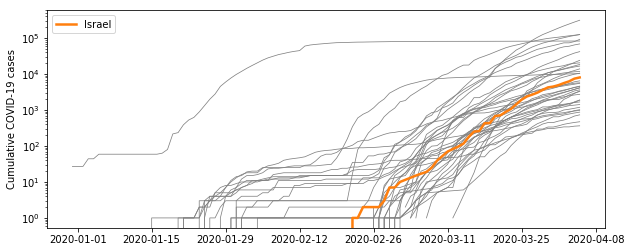

In [10]:
#! Look at what's important
def plot_dynamics(country_name, logscale=True):
    fig, ax = plt.subplots(figsize=(10, 4))
    to_label = []
    labels = []
    for name, df in df_selected.groupby('country'):
        if country_name == name:
            clr = 'C1'
            lw = 2.5
            zorder = 9 # show this line above the others
            lbl = name
        else:
            clr = 'gray'
            lw = 0.75
            zorder = 0
            lbl = ''
            lbl=None
        line, = ax.plot(
            df.date, df.cumcases, '-', color=clr, lw=lw, 
            zorder=zorder  # <========= Z-Order does some magic !
        )
        if lbl:
            to_label.append(line)
            labels.append(lbl)
    if logscale:
        ax.set_yscale('log')
    ax.set_ylabel('Cumulative COVID-19 cases')
    ax.legend(to_label, labels)
    return ax
plot_dynamics('Israel')

### Compared to what? Normalize to the population size.


In [11]:
df_selected['cumcases_per_million'] = df_selected.cumcases / df_selected.population * 1e6

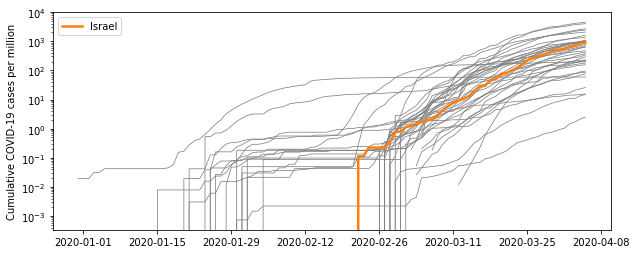

In [12]:

#! Plot the normalized data to reduce the clutter. Normalize to population size
def plot_normalized_population(country_name, logscale=True):
    fig, ax = plt.subplots(figsize=(10, 4))
    to_label = []
    labels = []
    for name, df in df_selected.groupby('country'):
        if country_name == name:
            clr = 'C1'
            lw = 2.5
            zorder = 9 # show this line above the others
            lbl = name
        else:
            clr = 'gray'
            lw = 0.75
            zorder = 0
            lbl = ''
            lbl=None
        line, = ax.plot(df.date, df.cumcases_per_million, '-', color=clr, lw=lw, zorder=zorder)
        if lbl:
            to_label.append(line)
            labels.append(lbl)
    ax.set_ylabel('Cumulative COVID-19 cases per million')
    ax.legend(to_label, labels)
    if logscale:
        ax.set_yscale('log')
    return ax
plot_normalized_population('Israel')

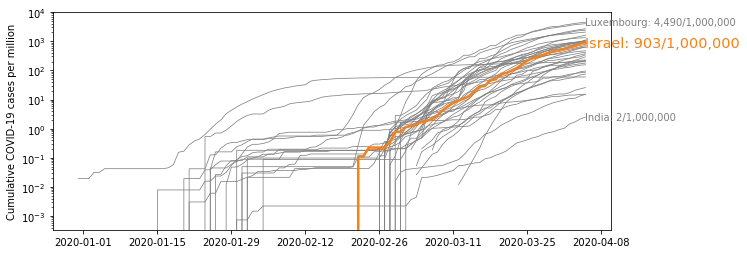

In [13]:
#! Let's make this prettier (*)
last_occurence = df_selected.groupby('country')['cumcases_per_million'].max().sort_values()
def plot_normalized_population(country_name, logscale=True):
    fig, ax = plt.subplots(figsize=(10, 4))
    for name, df in df_selected.groupby('country'):
        if country_name == name:
            clr = 'C1'
            lw = 2.5
            zorder = 9 # show this line above the others
            lbl = name
        else:
            clr = 'gray'
            lw = 0.75
            zorder = 0
            lbl = ''
            lbl=None
        ax.plot(df.date, df.cumcases_per_million, '-', color=clr, lw=lw, zorder=zorder)
            
        place_legend = False
        last_value = df.iloc[-1]['cumcases_per_million']
        if name == country_name:
            fontsize='x-large'
            place_legend = True
        elif name in (last_occurence.index[0], last_occurence.index[-1]):
            fontsize='medium'
            place_legend = True
        if place_legend:
            txt_x = df.date.max()
            ax.text(
                txt_x, last_value, f'{name}: {last_value:,.0f}/1,000,000',
                fontsize=fontsize, color=clr, va='center'
            )    
    ax.set_ylabel('Cumulative COVID-19 cases per million')
    if logscale:
        ax.set_yscale('log')
    return ax
plot_normalized_population('Israel')


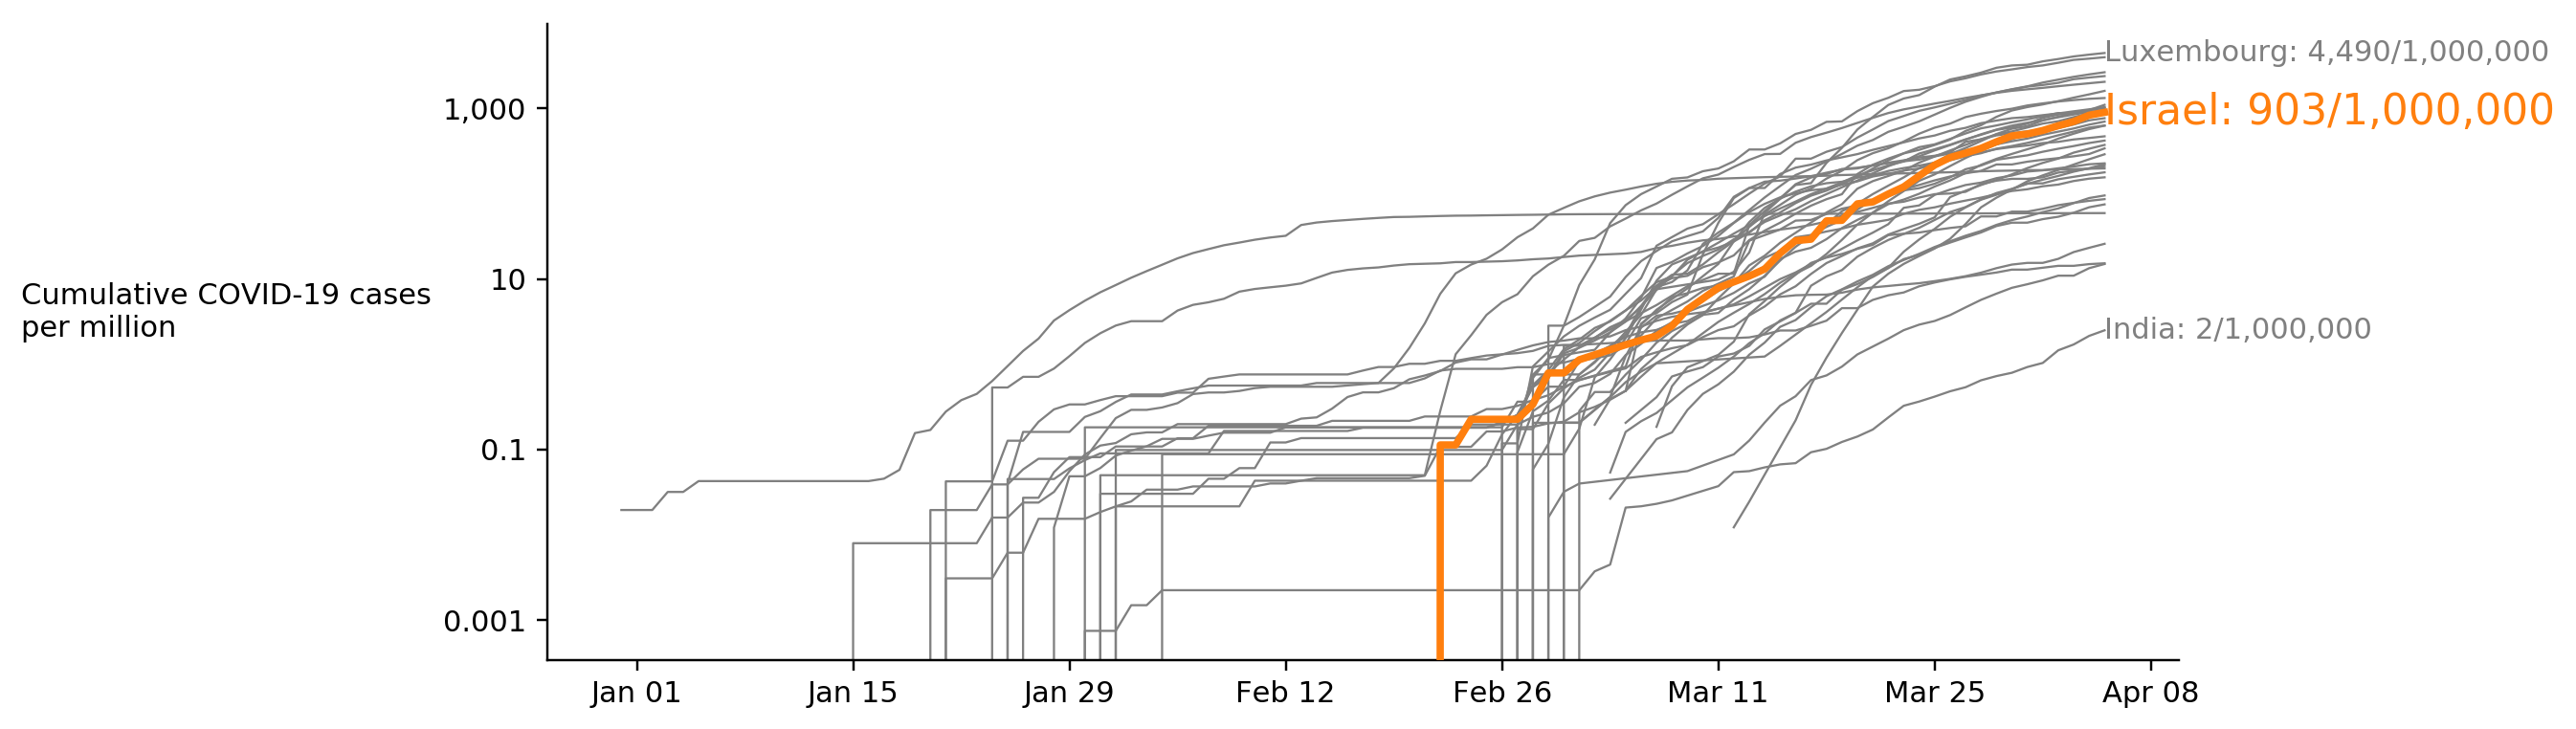

In [14]:
#! Let's make this EVEN PRETTIER (*)

def plot_normalized_population(country_name, logscale=True):
    fig, ax = plt.subplots(figsize=(10, 4), dpi=220)
    to_label = []
    labels = []
    for name, df in df_selected.groupby('country'):
        if country_name == name:
            clr = 'C1'
            lw = 2.5
            zorder = 9 # show this line above the others
            lbl = name
        else:
            clr = 'gray'
            lw = 0.75
            zorder = 0
            lbl = ''
            lbl=None
        ax.plot(df.date, df.cumcases_per_million, '-', color=clr, lw=lw, zorder=zorder)
            
        place_legend = False
        last_value = df.iloc[-1]['cumcases_per_million']
        if name == country_name:
            fontsize='x-large'
            place_legend = True
        elif name in (last_occurence.index[0], last_occurence.index[-1]):
            fontsize='medium'
            place_legend = True
        if place_legend:
            txt_x = df.date.max()
            ax.text(
                txt_x, last_value, f'{name}: {last_value:,.0f}/1,000,000',
                fontsize=fontsize, color=clr, va='center'
            )    
    ax.set_ylabel(
        'Cumulative COVID-19 cases\nper million',
        rotation=0,
        horizontalalignment='right', # ha='right' works too
        multialignment='left',  # ma='left' works too
    )
    if logscale:
        ax.set_yscale('log')
        tks = [10**i for i in (-3, -1, 1, 3)]
        lbls = ['0.001', '0.1', '10', '1,000']
        ax.set_yticks(tks)
        ax.set_yticklabels(lbls)
        ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())  
    sns.despine(ax=ax)
    ax.minorticks_off()
    ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b %d'))
    return fig
fig_after_1 = plot_normalized_population('Israel')

In [15]:
#! Add some interactivity
ipywidgets.interactive(
    plot_normalized_population,
    country_name=sorted(df_selected['country'].unique())
)

interactive(children=(Dropdown(description='country_name', options=('Australia', 'Austria', 'Belgium', 'Canada…

### Compared to what? Looking at the rates

In [16]:
# Normalize the values
def normalize_to_first10(df):
    ix_first = np.where(df.cumcases >=10)[0][0]
    ret = df.iloc[ix_first:].copy()
    ret['days_since_10'] = (ret.date - ret.date.min()).dt.days
    return ret
df_normalized_10 = df_selected.groupby(df_selected.index).apply(normalize_to_first10)
df_normalized_10.index = df_normalized_10.index.droplevel(0).values

In [17]:
df_normalized_10.loc['ISR'].head()

,dateRep,cases,deaths,country,geoId,population,date,cumcases,cumcases_per_million,days_since_10
ISR,02/03/2020,3,0,Israel,IL,8883800.0,2020-03-02,10,1.125644,0
ISR,05/03/2020,5,0,Israel,IL,8883800.0,2020-03-05,15,1.688467,3
ISR,06/03/2020,2,0,Israel,IL,8883800.0,2020-03-06,17,1.913596,4
ISR,07/03/2020,2,0,Israel,IL,8883800.0,2020-03-07,19,2.138724,5
ISR,08/03/2020,6,0,Israel,IL,8883800.0,2020-03-08,25,2.814111,6


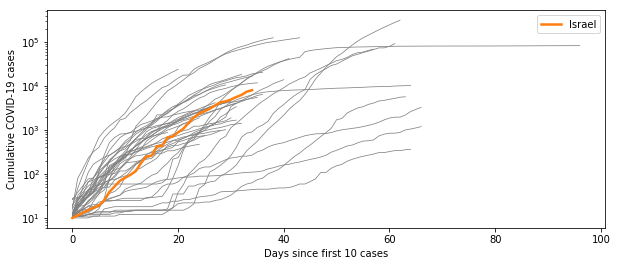

In [18]:
def plot_normalized_10(country_name, logscale=True):
    fig, ax = plt.subplots(figsize=(10, 4))
    to_label = []
    labels = []
    for name, df in df_normalized_10.groupby('country'):
        if country_name == name:
            clr = 'C1'
            lw = 2.5
            zorder = 9 # show this line above the others
            lbl = name
        else:
            clr = 'gray'
            lw = 0.75
            zorder = 0
            lbl = ''
            lbl=None
        line, = ax.plot(df.days_since_10, df.cumcases, '-', color=clr, lw=lw, zorder=zorder)
        if lbl:
            to_label.append(line)
            labels.append(lbl)
    ax.set_ylabel('Cumulative COVID-19 cases')
    ax.set_xlabel('Days since first 10 cases')
    ax.legend(to_label, labels)
    if logscale:
        ax.set_yscale('log')
    return ax
plot_normalized_10('Israel')

In [19]:
def growth_params(x, y, tail=None):
    if tail is not None:
        x = x[-tail:]
        y = y[-tail:]
    rate, intercept = np.polyfit(x, np.log(y), 1)
    return rate, np.exp(intercept)
def doubling_time_from_rate(rate):
    return np.log(2) / rate

In [20]:
# Compute last week's data
df_growth_params = []
tail = 7
for country, df in df_normalized_10.groupby(df_normalized_10.country):
    rate, x1 = growth_params(df.days_since_10, df.cumcases, tail)
    df_growth_params.append({'rate': rate, 'x1': x1, 'country':country})
df_growth_params = pd.DataFrame(df_growth_params).set_index('country').sort_values('rate')

In [21]:
def add_growth_extrapolation(df, country, lw, color, zorder, ax):
    rate, c1 = growth_params(df.days_since_10, df.cumcases, tail)
    x = np.arange(df.days_since_10.iloc[-2*tail], df.days_since_10.iloc[-1]  + 2 * tail)
    y = c1 * np.exp(rate * x)
    if lw > 1:
        fontsize = 'large'
    else:
        fontsize = 'medium'
    ax.plot(
        x, y, '--', 
        lw=lw-1, color=color, zorder=zorder
    )
    doubling_time = doubling_time_from_rate(rate)
    ax.text(
        x[-1], y[-1], f'{country}\n(doubles every {doubling_time:.1f} days)',
        ha='left', va='center', zorder=zorder,
        color=color, fontsize=fontsize,
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.75)  # <===== To make sure the text is readable
    )
    return ax

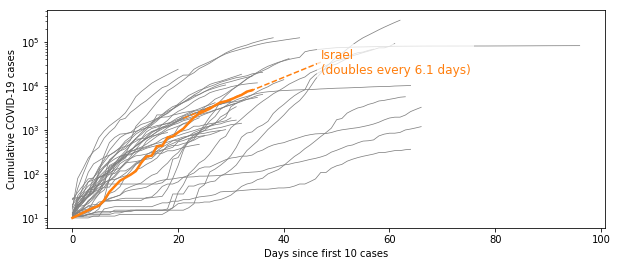

In [22]:
def plot_normalized_10_ref(country_name, logscale=True):
    fig, ax = plt.subplots(figsize=(10, 4))
    for name, df in df_normalized_10.groupby('country'):
        if country_name == name:
            clr = 'C1'
            lw = 2.5
            zorder = 9 # show this line above the others
            lbl = name
            tail = 7
            add_growth_extrapolation(df, country=name, lw=lw, color=clr, ax=ax, zorder=9)
        else:
            clr = 'gray'
            lw = 0.75
            zorder = 0
            lbl = ''
            lbl=None
        ax.plot(df.days_since_10, df.cumcases, '-', color=clr, lw=lw, zorder=zorder)
    ax.set_ylabel('Cumulative COVID-19 cases')
    ax.set_xlabel('Days since first 10 cases')    
    if logscale:
        ax.set_yscale('log')
    return ax
plot_normalized_10_ref('Israel')

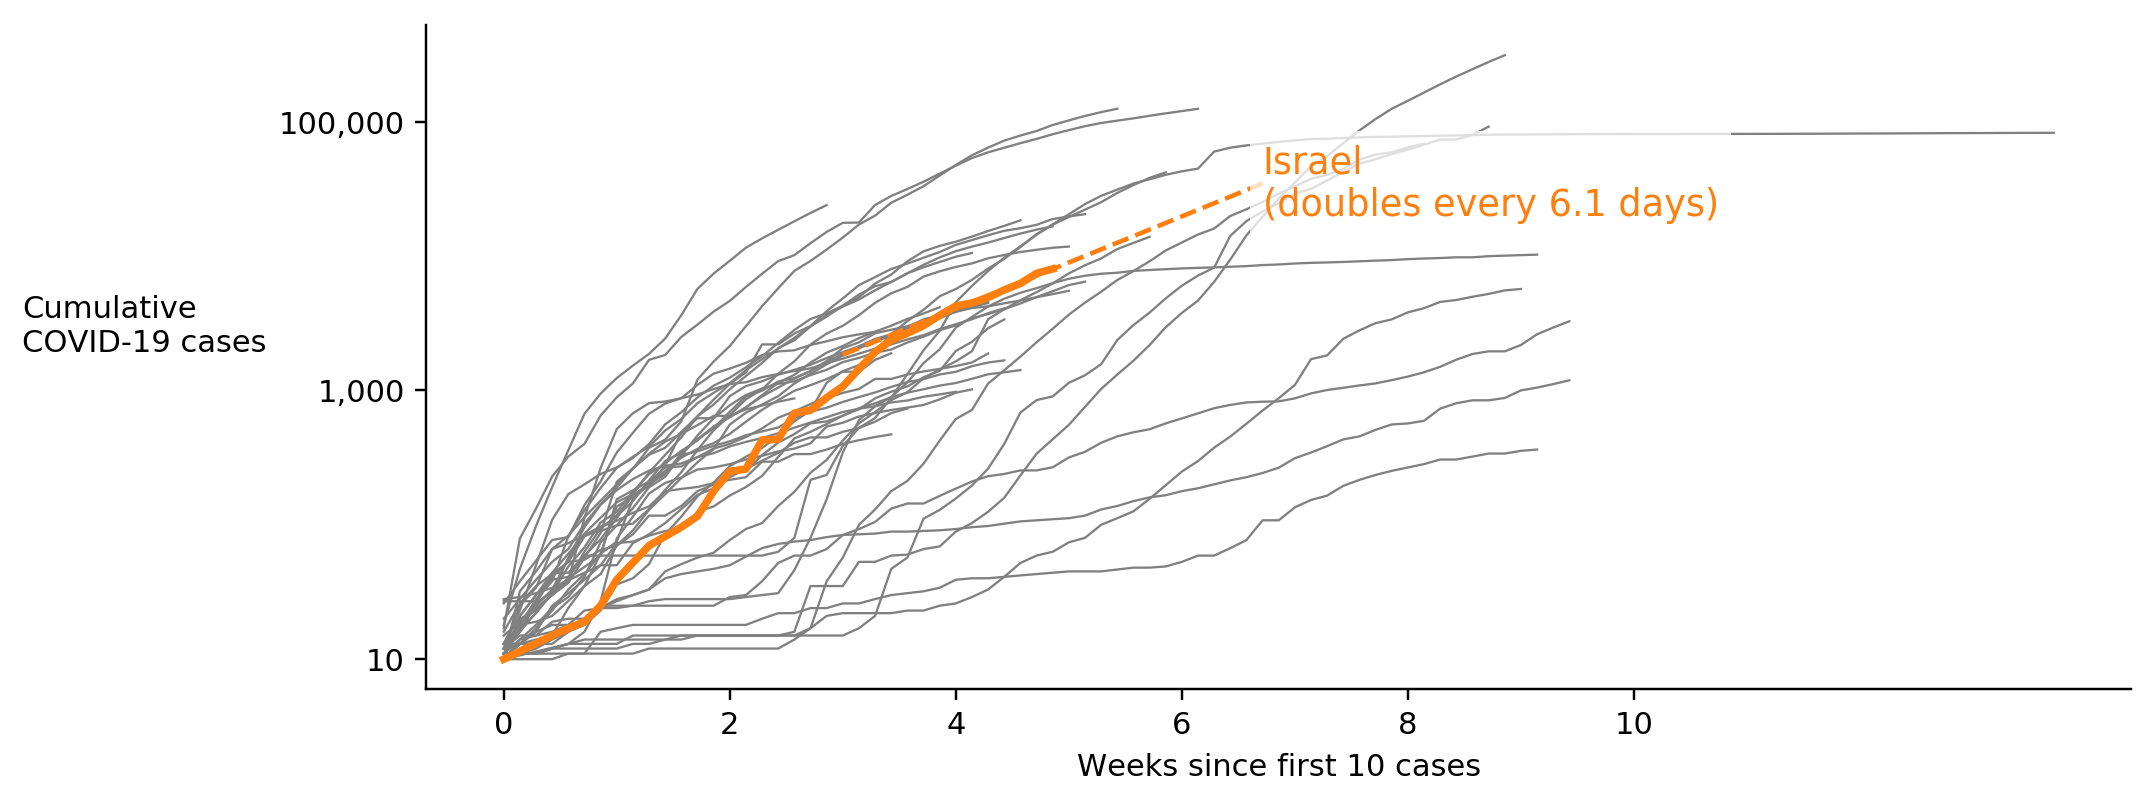

In [23]:
# Make it pretty now

def plot_normalized_10_ref(country_name, logscale=True):
    fig, ax = plt.subplots(figsize=(10, 4), dpi=220)
    for name, df in df_normalized_10.groupby('country'):
        if country_name == name:
            clr = 'C1'
            lw = 2.5
            zorder = 9 # show this line above the others
            tail = 10
            add_growth_extrapolation(df, country=name, lw=lw, color=clr, ax=ax, zorder=9)
        else:
            clr = 'gray'
            lw = 0.75
            zorder = 0
            lbl=None
        ax.plot(df.days_since_10, df.cumcases, '-', color=clr, lw=lw, zorder=zorder)
    ax.set_ylabel(
            'Cumulative\nCOVID-19 cases',
            rotation=0,
            horizontalalignment='right', # ha='right' works too
            multialignment='left',  # ma='left' works too
        )
    xtks = range(0, 80, 14)
    ax.set_xticks(xtks)
    lbls = [t//7 for t in xtks]
    ax.set_xticklabels(lbls)
    ax.set_xlabel('Weeks since first 10 cases')    
    if logscale:
        ax.set_yscale('log')
        tks = [10**i for i in range(1, 6, 2)]
        lbls = [f'{t:,d}' for t in tks]
        ax.set_yticks(tks)
        ax.set_yticklabels(lbls)
    sns.despine(ax=ax)
    ax.minorticks_off()
    return fig
fig_after_2 = plot_normalized_10_ref('Israel')

In [24]:
#! Add some interactivity
ipywidgets.interactive(
    plot_normalized_10_ref,
    country_name=sorted(df_selected['country'].unique())
)

interactive(children=(Dropdown(description='country_name', options=('Australia', 'Austria', 'Belgium', 'Canada…

## Conclusion

## Before ...

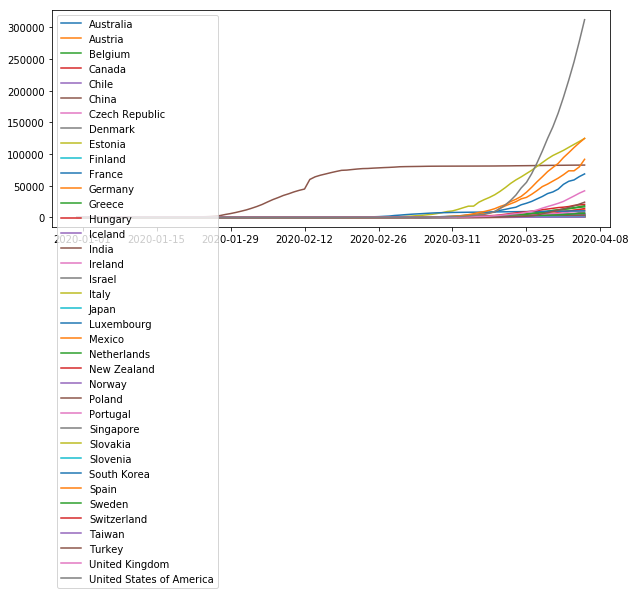

In [25]:
fig_default

## ... and after

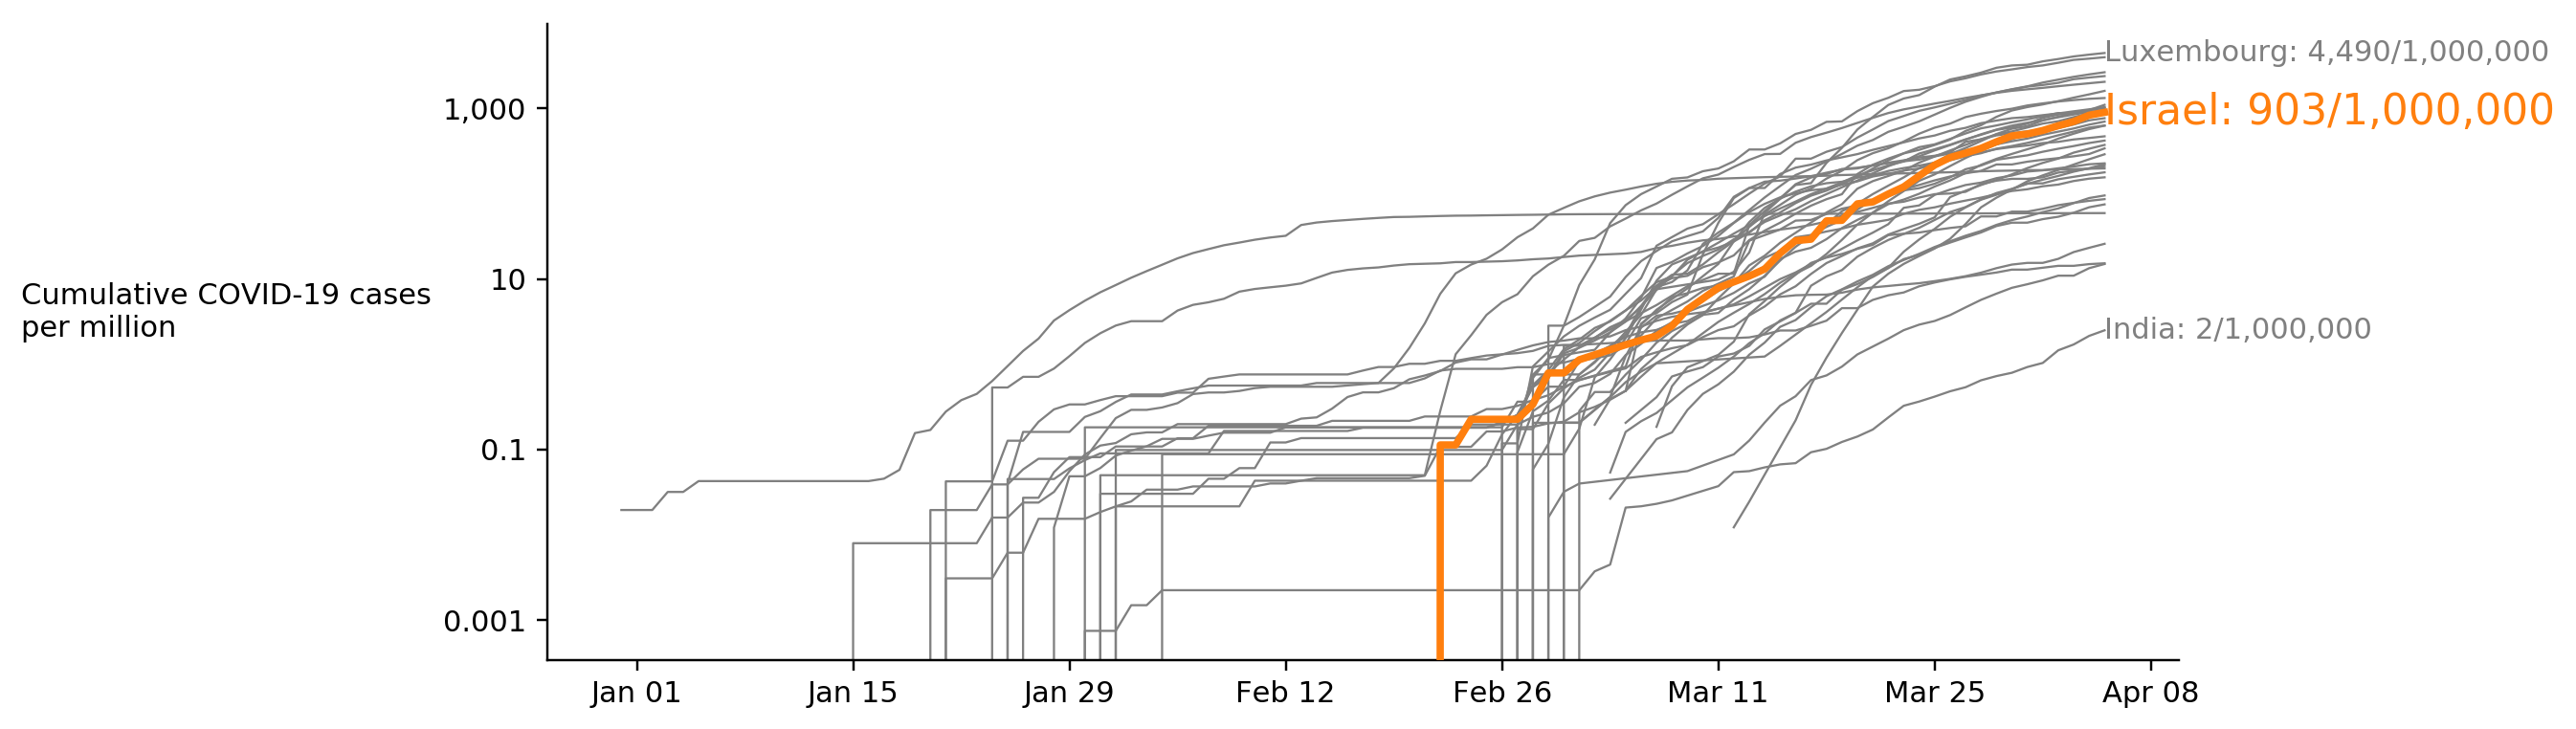

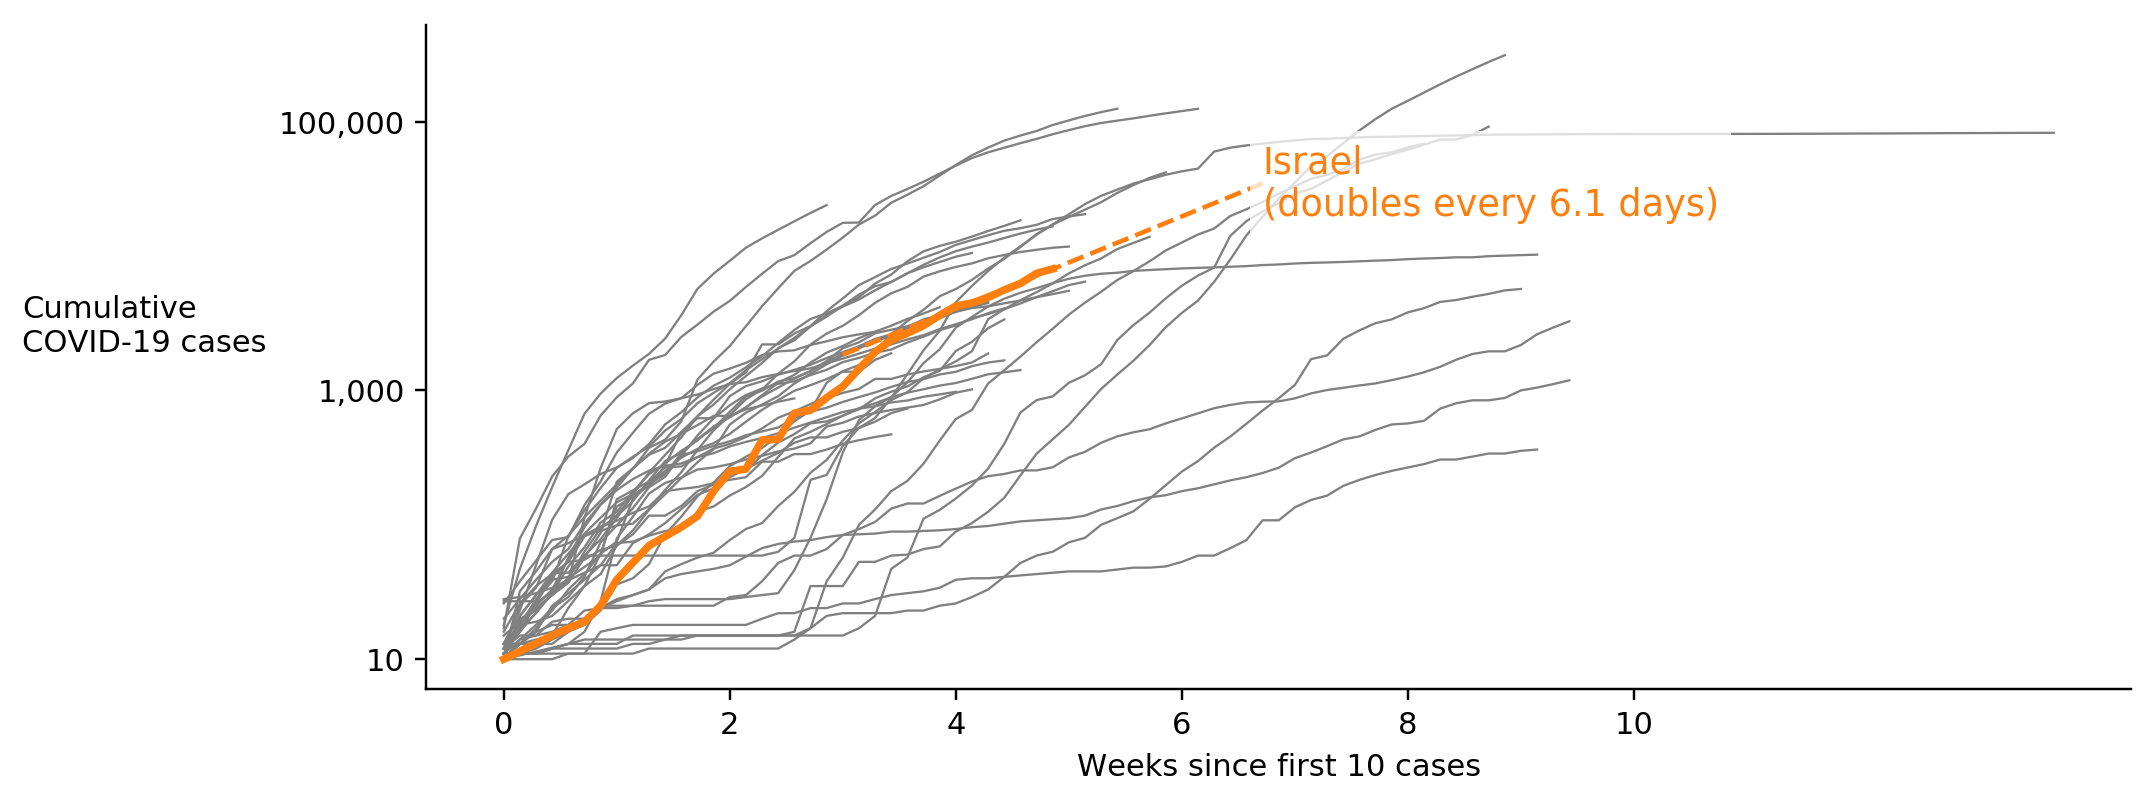

In [26]:
display(fig_after_1)
display(fig_after_2)